# Processing

### Initialization

In [1]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 134.  141.  128. ...,   81.   57.   74.]


In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((120,160)),cmap='Greys_r')

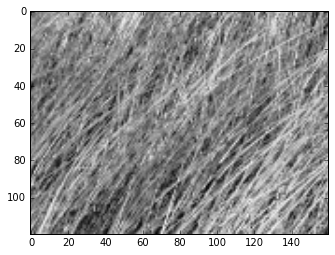

In [3]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)

sample = (sample - sample_mean)/sample_std # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 23.73651164 -20.94734111  23.281226    22.6802055   -7.50919708
  34.30870091 -12.46201579   8.07417771 -12.95784813   9.80002935
  -6.88500422   0.63095893 -13.29798142  19.54781085  -4.42927045
   2.70507576  -5.53067023   4.97089492  -7.19820107  13.64289273]


In [5]:
print(sample)

[[-0.69202207 -0.33728198 -1.24244061 ..., -0.58060361 -1.63538172
  -1.39232266]
 [-0.05946076 -0.23889167 -1.33391761 ..., -0.58060361 -1.31350687
   2.20405696]
 [ 0.20410645 -1.12440446 -1.19670211 ..., -0.37804055  1.74430416
   1.81997759]
 ..., 
 [-2.00985812  0.4498405  -1.01374811 ..., -0.46485329 -0.12256994
   1.08673514]
 [ 1.57465594  0.25305988 -0.69357861 ..., -0.66741635  2.00180404
  -0.27500083]
 [ 0.25681989  0.89259689  0.95300738 ..., -0.52272845  0.68211717
  -0.03058668]]


## Kernels

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **class Linear**(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **class RBF**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **class Poly**(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **class RatQuad**(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **class MLP**(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **class Matern32**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

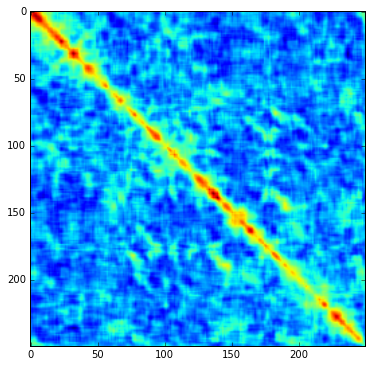

In [6]:
import GPy

fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Linear(Q).K(X,X))

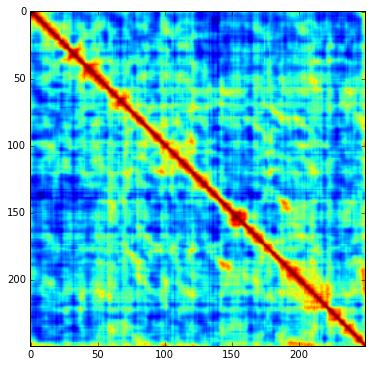

In [7]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RBF(Q,1,100).K(X,X))

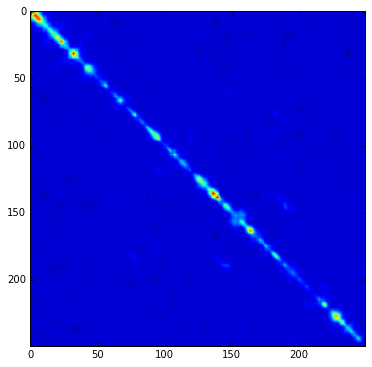

In [8]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Poly(Q,1,100).K(X,X))

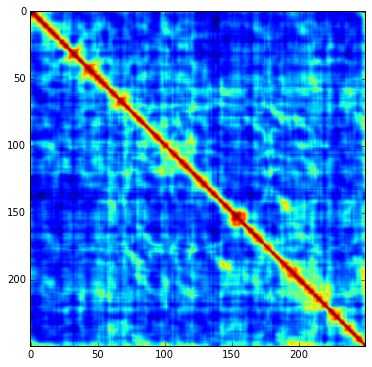

In [9]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RatQuad(Q,1,100).K(X,X))

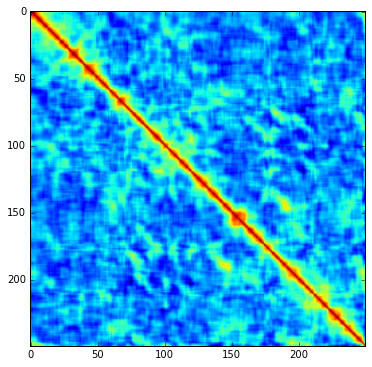

In [10]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.MLP(Q,1,100).K(X,X))

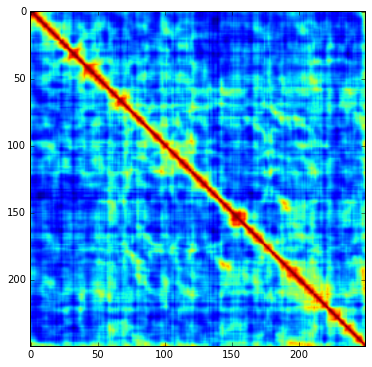

In [11]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Matern52(Q,1,100).K(X,X))

### Optimization

Kronecker Delta function:

In [12]:
def kd(x1,x2):
    
    if np.any(x1 == x2):
        return 1
    else:
        return 0

In [13]:
def kd2(N,x):
    
    result = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            result[i,j] = kd(x[i,:],x[j,:])
    
    return result

Kernel matrices:

In [14]:
def K_x(N,Q,w,x1,x2):
    
    k1 = GPy.kern.Linear(Q).K(x1[0:N-1,:],x2[0:N-1,:])
    k2 = GPy.kern.RBF(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k3 = GPy.kern.Poly(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k4 = GPy.kern.RatQuad(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k5 = GPy.kern.MLP(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k6 = GPy.kern.Matern52(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return w[0]*k1 + w[1]*k2 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd2(N-1,x1) + w[2]*k3 

In [15]:
def K_x_kern(Q):
    
    k1 = GPy.kern.Linear(Q)
    k2 = GPy.kern.RBF(Q,1,100)
    k3 = GPy.kern.Poly(Q,1,100)
    k4 = GPy.kern.RatQuad(Q,1,100)
    k5 = GPy.kern.MLP(Q,1,100)
    k6 = GPy.kern.Matern52(Q,1,100)
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return k1 + k2 + k4 + k5 + k6# + kd2(N-1,x1)# + w[2]*k3 

In [16]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1)) + theta[2]*kd(x1,x2)

In [17]:
def K_y_kern(Q):
    
    return GPy.kern.RBF(Q,1,100)# + theta[2]*kd(x1,x2)

Functions to optimize:

In [18]:
def f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.trace(np.matmul(Ky_inv,np.matmul(Y,np.linalg.pinv(Y))))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx))
    part4 = 0.5*np.trace(np.matmul(Kx_inv,np.matmul(X[1:N],np.transpose(X[1:N]))))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [19]:
def f2_likelihood(N,Q,Kx,X,W):
    
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N])))
    part3 = alpha*np.linalg.norm(W,2)

    return part1 + part2 + part3

Kx kernel matrix test:

[[ 4708.46577625  5300.51240898  5432.67350878 ...,  1263.3018179
   1721.7195948   1707.08131007]
 [ 5300.51240898  6422.41032769  6751.19375397 ...,  1364.89793108
   1876.76047981  1914.4848525 ]
 [ 5432.67350878  6751.19375397  7374.51659116 ...,  1471.90906741
   2006.54533349  2088.61590912]
 ..., 
 [ 1263.3018179   1364.89793108  1471.90906741 ...,  4020.46086512
   2854.78261545  1325.66019282]
 [ 1721.7195948   1876.76047981  2006.54533349 ...,  2854.78261545
   2753.86384763  1803.35767487]
 [ 1707.08131007  1914.4848525   2088.61590912 ...,  1325.66019282
   1803.35767487  1936.77273337]]
4.38393112938e+136
314.629518487


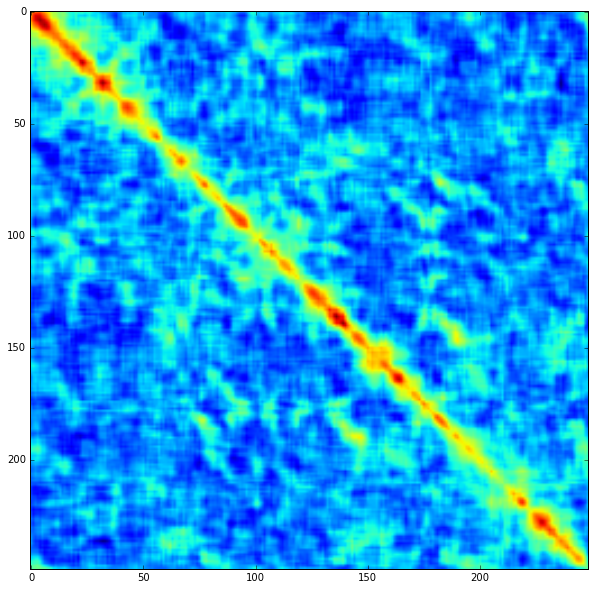

In [20]:
weights = [1, 1, 0, 1, 1, 1, 1]
Kx = K_x(N,Q,weights,X,X)

print(Kx)
print(np.linalg.det(Kx))
print(np.log(np.linalg.det(Kx)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Kx)

Ky kernel matrix test:

In [ ]:
theta = [1, 0.0001, 0]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))
theta = [1, 0.0001, 0]
Ky = Ky + theta[2]*kd2(N,X)

print(Ky)
print(np.log(np.linalg.det(Ky)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)

f1_likelihood test:

In [ ]:
np.matmul(np.transpose(sample),np.matmul(np.linalg.inv(Ky),sample)).sum()

In [ ]:
np.trace(np.matmul(np.linalg.inv(Ky),np.matmul(sample,np.linalg.pinv(sample))))

In [ ]:
lamb = [1, 1, 1, 1, 1, 1]

print(f1_likelihood(N,D,Q,Kx,Ky,X,sample,theta,lamb))

f2_likelihood test:

In [ ]:
#a = [[1,0,0],[0,1,0],[0,0,1]]
#x = [9,8,7,6]
#c = [1,2,3,4,5,6]
#print(f2_likelihood(20,4,a,x,c))

print(f2_likelihood(N,Q,Kx,X,weights))

Gradients of functions f1 and f2:

In [ ]:
def f1_gradient(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    dKy_dX = K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dKx_dX = K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dx2_dX = np.ones((Q,Q)) # OK-?
    
    dL_dX = np.matmul(dL_dKy[0:N-1,0:N-1],dKy_dX) 
    dL_dX = dL_dX + np.matmul(dL_dKx,dKx_dX)
    dL_dX = dL_dX + np.matmul(dL_dx2,dx2_dX)
    
    """dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3"""
    
    return dL_dX #[dL_dX, dL_dTheta, dL_dLam]

In [ ]:
a = K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
print(a)

In [ ]:
print(np.size(a))

In [ ]:
K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])

In [ ]:
def f2_gradient2(N,Q,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g)
    
    return -np.transpose(g)

In [ ]:
def f2_gradient(N,Q,Kx,X,W):
    
    Kx_inv = np.linalg.inv(Kx)    
    
    dF_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    
    dF_dW = np.sum(dF_dKx) * np.sum(Kx) + W/np.linalg.norm(W,2)
    
    return dF_dW

f1_gradient test:

In [ ]:
gradf1 = f1_gradient(N,D,Q,Kx,Ky,X,sample,theta,lamb)
print(gradf1)
print(np.size(gradf1))

f2_gradient test:

In [ ]:
W = [1,1,0,1,1,1,1]
gradf2 = f2_gradient(N,Q,Kx,X,W)
print(gradf2)
print(np.size(gradf2))

In [ ]:
w = np.transpose(W)
check = GPy.models.GradientChecker(lambda a: f2_likelihood(N,Q,Kx,X,a),lambda b: f2_gradient(N,Q,Kx,X,b),x0 = w.copy())
check.checkgrad(verbose=1)

In [ ]:
# TODO: 

#[params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)

In [ ]:
#m = GPy.examples.dimensionality_reduction.mrd_simulation(optimize = False)
#m.optimize(messages = True, max_f_eval=5000, optimizer = 'SCG')

In [ ]:
help(GPy.models.GPLVM)

In [5]:
import GPy

kernel = GPy.kern.Linear(Q, ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

In [6]:
m.optimize(messages=True, optimizer = 'SCG', max_iters=10)

In [7]:
print(m.X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -0.86027917  |               |        
  [0 1]      |         0.83576395  |               |        
  [0 2]      |        -1.06868890  |               |        
  [0 3]      |         1.19103175  |               |        
  [0 4]      |        -0.39975191  |               |        
  [0 5]      |         1.84270725  |               |        
  [0 6]      |        -0.69920996  |               |        
  [0 7]      |         0.47706370  |               |        
  [0 8]      |        -0.81140286  |               |        
  [0 9]      |         0.63158272  |               |        
  [ 0 10]    |        -0.45091007  |               |        
  [ 0 11]    |         0.04157984  |               |        
  [ 0 12]    |        -0.89027693  |               |        
  [ 0 13]    |         1.34478583  |               |        
  [ 0 14]    |        -0.31344719  |               |        
  [ 0 15]    |         0

In [10]:
X = m.X
Kx = kernel.K(X)
print(Kx)

[[ 0.17671713  0.19534685  0.20207263 ...,  0.07457619  0.06306292
   0.03659819]
 [ 0.19534685  0.23898301  0.25540329 ...,  0.07781479  0.06870143
   0.04012622]
 [ 0.20207263  0.25540329  0.28668634 ...,  0.08360316  0.07710955
   0.04361232]
 ..., 
 [ 0.07457619  0.07781479  0.08360316 ...,  0.12763333  0.07961648
   0.03817793]
 [ 0.06306292  0.06870143  0.07710955 ...,  0.07961648  0.08048272
   0.05773572]
 [ 0.03659819  0.04012622  0.04361232 ...,  0.03817793  0.05773572
   0.06036006]]


In [9]:
kernel2 = GPy.kern.Linear(Q, ARD=True)
print(kernel2.K(X))

[[ 13.88148973  15.28762291  15.8436898  ...,   6.01398252   4.93618769
    2.77874752]
 [ 15.28762291  18.73916411  20.09247373 ...,   6.22777171   5.34440804
    3.02922529]
 [ 15.8436898   20.09247373  22.67407079 ...,   6.69638426   6.03389579
    3.32080875]
 ..., 
 [  6.01398252   6.22777171   6.69638426 ...,  10.40074313   6.43914478
    3.09325088]
 [  4.93618769   5.34440804   6.03389579 ...,   6.43914478   6.44544142
    4.62700467]
 [  2.77874752   3.02922529   3.32080875 ...,   3.09325088   4.62700467
    4.86481498]]
